1. 단일책임원칙
2. 개방폐쇄원칙
3. 리스코프치환원칙
4. 인터페이스분리원칙+의존성역전

# 1. Interface segregation

- interface
  - object에 구현된 method에 의해 표현됨
  - python은 duck typing principle에 의해 class 내에 구현된 method들에 의해 interface가 정의됨
    - duck typing
      - 만약 사람이 오리처럼 걷고, 헤엄지고 꽥꽥소리를 내면 오리로 봐도 무방하다  
$\Rightarrow$ class method에 의해 객체를 정의하자는 의미인듯하다
      - 참고: https://nesoy.github.io/articles/2018-02/Duck-Typing
  - 이러한 duck typing 방식은 python3에서 Abstract Base Class (ABC)가 생겨나며 `(abc.ABC)` 를 사용하는쪽으로 변경됨
    - abc.ABC base class는 하위 class에서 구현해야되는 method 들을 강제로 지정 할 수 있음

- interface separation principle
  - 많은 method를 포함하는 하나의 interface를 정의하기보다는 구체적인 범위를 정하고 적은 method를 갖는 여러개로 분리하는게 좋음  
  $\Rightarrow$ 코드 재사용성이나, 응집력이 높아짐

In [3]:
class Parrot:
    def fly(self):
        print("Parrot flying")

class Airplane:
    def fly(self):
        print("Airplane flying")

class Whale:
    def swim(self):
        print("Whale swimming")

def lift_off(entity):
    entity.fly()

parrot = Parrot()
airplane = Airplane()
whale = Whale()

In [4]:
lift_off(parrot) # prints `Parrot flying`

Parrot flying


In [5]:
lift_off(airplane) # prints `Airplane flying`

Airplane flying


In [6]:
lift_off(whale) # Throws the error `'Whale' object has no attribute 'fly'`

AttributeError: ignored

## 1.1. An interface that provides too much
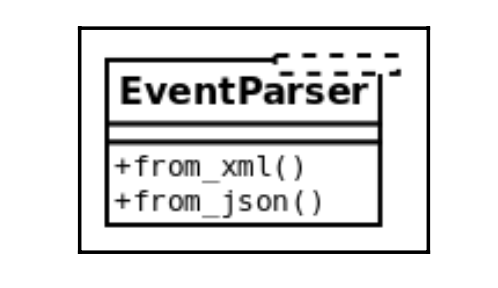

- 위와 같은 ABC가 있고, `from_xml, from_json`이 abstractmethod라면 subclass는 항상 이 둘을 구현해야됨
- 만약 JSON 만을 처리하는 subclass가 있다면 불필요한 여러 method들을 구현해야하는 번거로움이 발생함

In [8]:
import abc

In [13]:
class BaseEventParser(abc.ABC):

  @abc.abstractmethod
  def from_xml(self):
    pass

  @abc.abstractmethod
  def from_json(self):
    pass

In [19]:
class XMLEventParser(BaseEventParser):

  def from_xml(self):
    print('this is xml event parser')

class JSONEventParser(BaseEventParser):

  def from_json(self):
    print('this is json event parser')

In [20]:
xml_parser = XMLEventParser()

TypeError: ignored

In [21]:
json_parser = JSONEventParser()

TypeError: ignored

In [22]:
class XMLEventParser(BaseEventParser):

  def from_xml(self):
    print('this is xml event parser')

  def from_json(self):
    pass

In [23]:
xml_parser = XMLEventParser()

## 1.2. The smaller the interface, the better

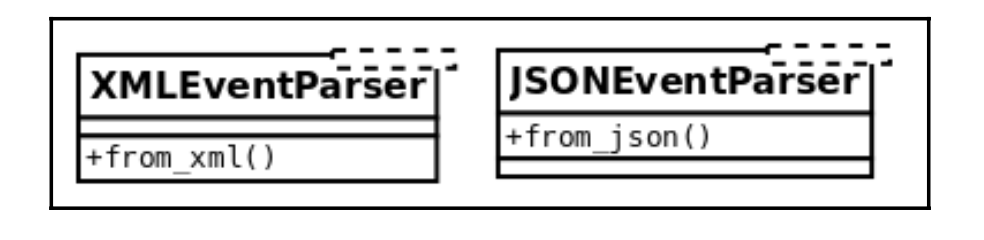

- `XMLEventParser`의 subclass는 `from_xml`만을 구현하면 됨
- 또한 `XMLEventParser`와 `JSONEventParser`간에 orthogonality도 유지되기 때문에 더 좋은 구조

## 1.3. How small should an interface be?
- 가능한 작은 단위로 분리해서 응집력을 높이도록 설계
- 그렇다고 각 subclass가 하나의 method만 포함할 필요는 없음
  - mixin pattern에서 context manager 로직을 구현하는 경우 `__enter__`, `__exit__` 두 개의 method를 구현

# 2. Dependency inversion
- 코드를 작성할때 통제하기 힘든 파트와 독립적이게 만들어 코드를 보호하기 위한 design principle
- 예시: 아래 상황의 경우 B는 통제할수 없는 부분으로 B에 큰 변화가 생기면 코드가 동작하지 않을 위험성이 존재함
  - A, B instance
  - A는 B를 직접 사용
  - B는 외부라이브러리에서 생성된 객체
- DIP는 이런 상황을 피하기 위해 B가 A에 의존하도록 반대로 설계하려는 원칙을 의미함
- **고수준 모듈은 저수준 모듈의 구현에 의존해서는 안 된다. 저수준 모듈이 고수준 모듈에서 정의한 추상 타입에 의존해야 한다**
- 참고 코드: https://github.com/doorBW/python_clean_code/blob/master/code_example/11_SOLID_DIP(Dependency_Injection_Principle).ipynb

## 2.1. A case of rigid dependencies
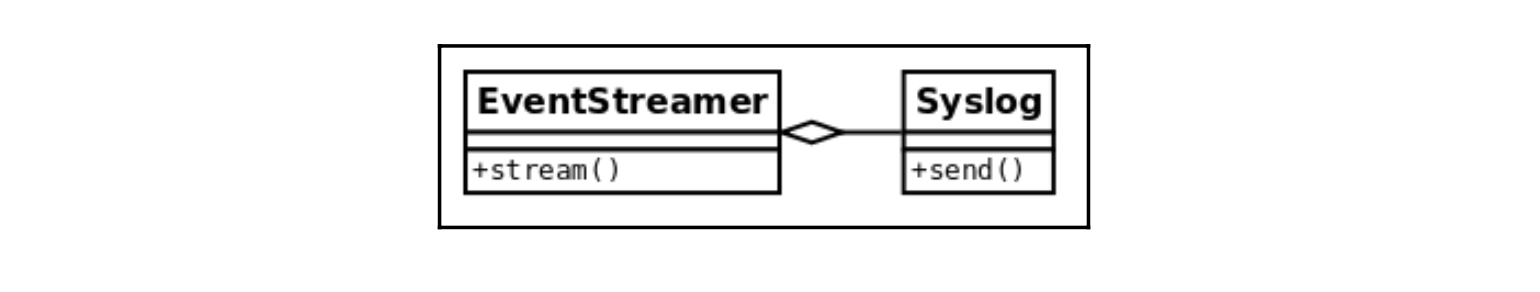

- 위 구조는 high-level class가 low-level class에 의존하고 있음
  - high-level class: `EventStreamer`
  - low-level class: `Syslog`
- `Syslog`에서 data를 보내는 방식이 변경되면 `EventStreamer`를 계속 수정해줘야 됨

In [41]:
import abc
        

class Syslog():
    def send(data: str):
        print(f"Syslog send: {data}")
        pass
    

class OtherClient():
    def send(data: str):
        print(f"OtherClient send: {data}")
        pass


class EventStreamer():
    def __init__(self, parsed_data: str, client: Syslog):
        self.parsed_data = parsed_data
        assert client is Syslog, "Client is not Syslog"
        self.client = client
        
    def stream(self):
        self.client.send(self.parsed_data)    

In [42]:
streamer1 = EventStreamer("for Syslog data!", Syslog)
streamer1.stream()

Syslog send: for Syslog data!


In [43]:
streamer2 = EventStreamer("for OtherClient data!", OtherClient)
streamer2.stream()

AssertionError: ignored

## 2.2. inverting the dependencies
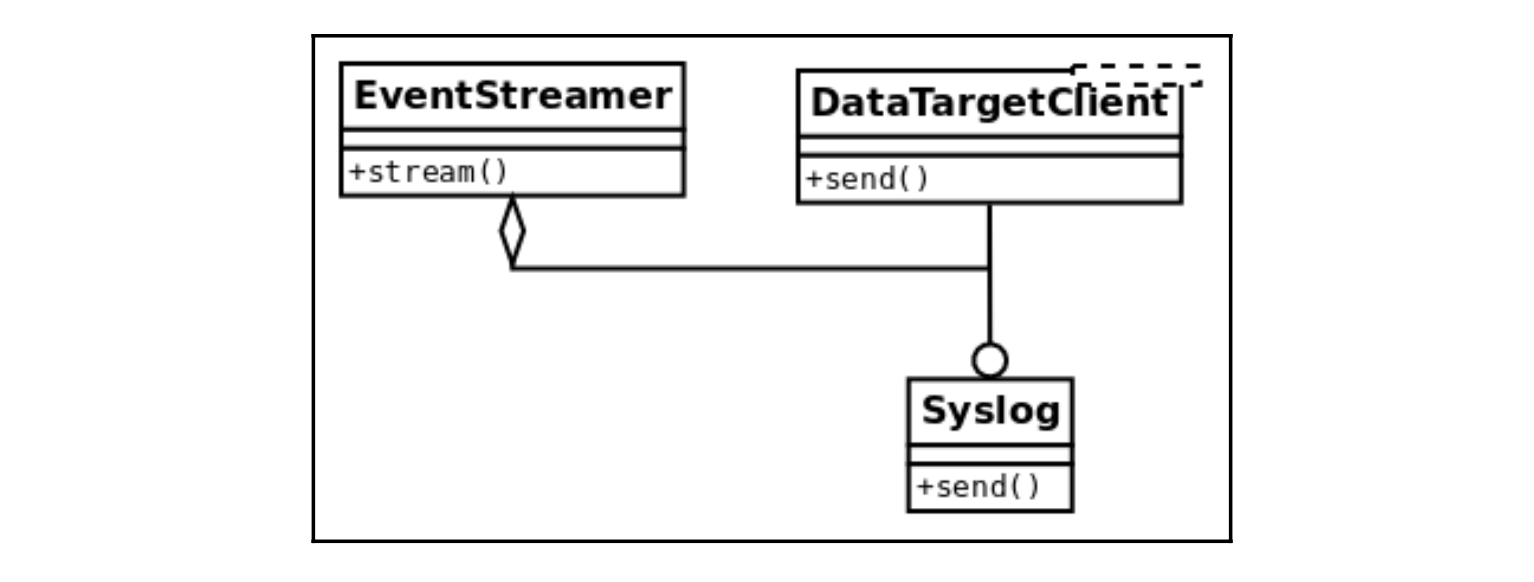

- 위와 같이 ABC로 `DataTargetClient`를 정의하면 `Syslog`와 같은 client는 해당 interfaced에 맞게 구현되야 함
- 이로 인해 `EventStreamer`가 `Syslog`에 의존하던 것과는 반대의 상황이 됨
- ABC를 안써도 코드가 동작하는데는 문제가 없지만 가독성과 이해도 측면에서 봤을때 더 clean architecture가 되기 때문에 이런 방식을 권장한다고 함

In [54]:
import abc


class DataTargetClient(metaclass=abc.ABCMeta):
    """Interface: DataTargetClient class"""
    @abc.abstractmethod
    def send(self, data: str):
        pass            


class Syslog(DataTargetClient):
    def send(data: str):
        print(f"Syslog send: {data}")
        pass


class OtherClient(DataTargetClient):
    def send(data: str):
        print(f"OtherClient send: {data}")
        pass


class EventStreamer():
    def __init__(self, parsed_data: str, client):
        self.parsed_data = parsed_data
        assert client in DataTargetClient.__subclasses__(), "Client is not DataTargetClient"
        self.client = client
        
    def stream(self):
        self.client.send(self.parsed_data)

In [56]:
streamer1 = EventStreamer("for Syslog data!", Syslog)
streamer1.stream()

Syslog send: for Syslog data!


In [57]:
streamer2 = EventStreamer("for OtherClient data!", OtherClient)
streamer2.stream()

OtherClient send: for OtherClient data!
